# **Assignment 2**
Evaluating the Impact of Augmentation, Dropout, and L2 Regularization on VGG16 and AlexNet with CIFAR-10  

## **Objective:**  
*   This assignment will explore the effects of data augmentation, dropout, and L2 regularization on the performance of VGG16 and AlexNet using the CIFAR-10 dataset.
*   You will implement multiple configurations of these techniques, analyze their impact on model accuracy, and evaluate other metrics such as training time and model complexity.



## **Import necessary libraries**

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import time
import numpy as np
import pandas as pd

# Verify GPU
print("GPU Available: ", tf.test.is_built_with_cuda())
print("Current device: ", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

GPU Available:  True
Current device:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Data Preprocessing**

In [ ]:
import tensorflow as tf

def load_and_preprocess_data():
    # Load CIFAR-10
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test


# **Model Architectures**  
## **VGG16**






In [ ]:
def create_vgg16(input_shape=(32, 32, 3), dropout_rate=None, l2_lambda=None):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None,
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(MaxPooling2D((2, 2)))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu',
                   kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    return model

## **Alexnet**

In [ ]:
def create_alexnet(input_shape=(32, 32, 3), dropout_rate=None, l2_lambda=None):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None,
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(384, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    model.add(MaxPooling2D((2, 2)))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(l2_lambda) if l2_lambda else None))
    if dropout_rate:
        model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    return model

# **Model Training**

In [ ]:
# Training function with timing
def train_model(model, X_train, y_train, X_test, y_test, epochs=5, batch_size=32,
                data_augmentation=False):
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    times_per_epoch = []
    training_accuracies = []

    if data_augmentation:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        datagen.fit(X_train)

        for epoch in range(epochs):
            start_time = time.time()
            history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=1,
                              validation_data=(X_test, y_test),
                              verbose=1)
            epoch_time = time.time() - start_time
            times_per_epoch.append(epoch_time)
            training_accuracies.append(history.history['accuracy'][0])
    else:
        start_time = time.time()
        history = model.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(X_test, y_test),
                          verbose=1)
        total_time = time.time() - start_time
        times_per_epoch = [total_time / epochs] * epochs
        training_accuracies = history.history['accuracy']

    # Evaluate final model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return {
        'training_accuracy': training_accuracies[-1],
        'test_accuracy': test_acc,
        'training_time_per_epoch': np.mean(times_per_epoch),
        'parameters': model.count_params()
    }


# **Experiments:**
*   Baseline
*   Data Augmentation
*   Dropout
*   L2 Regularization
*   Combined Techniques



In [ ]:
# Main experiment execution
def run_experiments():
    # Load and preprocess data
    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    results = []

    # Baseline experiments
    print("\nRunning baseline experiments...")
    for model_name, model_fn in [('VGG16', create_vgg16), ('AlexNet', create_alexnet)]:
        print(f"\nTraining baseline {model_name}")
        model = model_fn()
        history = train_model(model, X_train, y_train, X_test, y_test)
        results.append({
            'Configuration': 'Baseline',
            'Model': model_name,
            'Training Accuracy': history['training_accuracy'],
            'Test Accuracy': history['test_accuracy'],
            'Training Time Per Epoch': history['training_time_per_epoch'],
            'Parameters': history['parameters'],
            'Details': 'None'
        })

    # Data augmentation experiments
    print("\nRunning data augmentation experiments...")
    for model_name, model_fn in [('VGG16', create_vgg16), ('AlexNet', create_alexnet)]:
        print(f"\nTraining {model_name} with data augmentation")
        model = model_fn()
        history = train_model(model, X_train, y_train, X_test, y_test, data_augmentation=True)
        results.append({
            'Configuration': 'Data Augmentation',
            'Model': model_name,
            'Training Accuracy': history['training_accuracy'],
            'Test Accuracy': history['test_accuracy'],
            'Training Time Per Epoch': history['training_time_per_epoch'],
            'Parameters': history['parameters'],
            'Details': 'Basic augmentations (rotation=15°, width_shift=0.1, height_shift=0.1, horizontal_flip)'
        })

    # Dropout experiments
    print("\nRunning dropout experiments...")
    for dropout_rate in [0.2, 0.5]:
        for model_name, model_fn in [('VGG16', create_vgg16), ('AlexNet', create_alexnet)]:
            print(f"\nTraining {model_name} with dropout {dropout_rate}")
            model = model_fn(dropout_rate=dropout_rate)
            history = train_model(model, X_train, y_train, X_test, y_test)
            results.append({
                'Configuration': f'Dropout ({dropout_rate})',
                'Model': model_name,
                'Training Accuracy': history['training_accuracy'],
                'Test Accuracy': history['test_accuracy'],
                'Training Time Per Epoch': history['training_time_per_epoch'],
                'Parameters': history['parameters'],
                'Details': f'Dropout {dropout_rate} on FC layers'
            })

    # L2 regularization experiments
    print("\nRunning L2 regularization experiments...")
    for l2_lambda in [0.0001, 0.001]:
        for model_name, model_fn in [('VGG16', create_vgg16), ('AlexNet', create_alexnet)]:
            print(f"\nTraining {model_name} with L2 regularization {l2_lambda}")
            model = model_fn(l2_lambda=l2_lambda)
            history = train_model(model, X_train, y_train, X_test, y_test)
            results.append({
                'Configuration': f'L2 Regularization ({l2_lambda})',
                'Model': model_name,
                'Training Accuracy': history['training_accuracy'],
                'Test Accuracy': history['test_accuracy'],
                'Training Time Per Epoch': history['training_time_per_epoch'],
                'Parameters': history['parameters'],
                'Details': f'L2 = {l2_lambda} on all layers'
            })

    # Combined techniques
    print("\nRunning combined techniques experiments...")
    for model_name, model_fn in [('VGG16', create_vgg16), ('AlexNet', create_alexnet)]:
        print(f"\nTraining {model_name} with combined techniques")
        model = model_fn(dropout_rate=0.2, l2_lambda=0.0001)
        history = train_model(model, X_train, y_train, X_test, y_test, data_augmentation=True)

        # Measure inference time
        start_time = time.time()
        model.predict(X_test, batch_size=32)
        inference_time = time.time() - start_time

        results.append({
            'Configuration': 'Full Configuration',
            'Model': model_name,
            'Training Accuracy': history['training_accuracy'],
            'Test Accuracy': history['test_accuracy'],
            'Training Time Per Epoch': history['training_time_per_epoch'],
            'Inference Time': inference_time,
            'Parameters': history['parameters'],
            'Details': 'Aug + Drop(0.2) + L2(0.0001)'
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    column_order = [
        'Configuration', 'Model', 'Training Accuracy', 'Test Accuracy',
        'Training Time Per Epoch', 'Inference Time', 'Parameters', 'Details'
    ]
    results_df = results_df[column_order]
    return results_df

# **Results**

In [ ]:
# Execute all experiments
if __name__ == "__main__":
    # Run all experiments
    results_df = run_experiments()

    # Display results
    print("\nFinal Results Summary:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(results_df.to_string(index=False))

    # Save results to CSV
    results_df.to_csv('regularization_results.csv', index=False)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training samples: 50000
Test samples: 10000

Running baseline experiments...

Training baseline VGG16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.3122 - loss: 1.8335 - val_accuracy: 0.5978 - val_loss: 1.1202
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6188 - loss: 1.0620 - val_accuracy: 0.6752 - val_loss: 0.9157
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7081 - loss: 0.8221 - val_accuracy: 0.7098 - val_loss: 0.8306
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7662 - loss: 0.6615 - val_accuracy: 0.7099 - val_loss: 0.8512
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8079 - loss: 0.5481 - val_accuracy: 0.7017 - val_loss: 0.9871

Training baseline AlexNet
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.2629 - loss: 1.9546 - val_accuracy: 0.5261 - val_loss: 1.3054
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.5514 - loss: 1.2394 - val_accuracy: 0.6279 - val_loss: 1.0392
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - ac

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.2998 - loss: 1.8759 - val_accuracy: 0.5283 - val_loss: 1.3629
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.5544 - loss: 1.2375 - val_accuracy: 0.6428 - val_loss: 1.0131
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.6270 - loss: 1.0503 - val_accuracy: 0.6835 - val_loss: 0.9033
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.6740 - loss: 0.9255 - val_accuracy: 0.7052 - val_loss: 0.8585
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.7091 - loss: 0.8353 - val_accuracy: 0.6992 - val_loss: 0.8819

Training AlexNet with data augmentation


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.2568 - loss: 1.9647 - val_accuracy: 0.5068 - val_loss: 1.3395
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.5132 - loss: 1.3408 - val_accuracy: 0.5883 - val_loss: 1.1451
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.5825 - loss: 1.1584 - val_accuracy: 0.6342 - val_loss: 1.0575
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6230 - loss: 1.0525 - val_accuracy: 0.6668 - val_loss: 0.9438
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6504 - loss: 0.9890 - val_accuracy: 0.6829 - val_loss: 0.9121

Running dropout experiments...

Training VGG16 with dropout 0.2
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.3131 - loss: 1.8379 - val_accuracy: 0.5855 - val_loss: 1.1613
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6007 - loss: 1.1163 - val_accuracy: 0.6764 - val_loss: 0.9315
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6

# **Visualizations**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualizations(results_df):
    """
    Visualizations to support my analysis

    Parameters:
    results_df: pandas DataFrame with experiment results
    """
    # Set style and color parameters
    plt.style.use('seaborn')
    colors = {
        'vgg16': '#2E86C1',  # Blue
        'alexnet': '#28B463',  # Green
        'gap': '#AED6F1'  # Light blue
    }

    # Set figure size
    plt.figure(figsize=(15, 20))

    # 1. Model Accuracy Comparison
    plt.subplot(4, 1, 1)
    plot_accuracy_comparison(results_df, colors)

    # 2. Training Time vs Accuracy
    plt.subplot(4, 1, 2)
    plot_time_vs_accuracy(results_df, colors)

    # 3. Model Size vs Accuracy
    plt.subplot(4, 1, 3)
    plot_size_vs_accuracy(results_df, colors)

    # 4. Regularization Effects
    plt.subplot(4, 1, 4)
    plot_regularization_effects(results_df, colors)

    plt.tight_layout(pad=3.0)
    plt.show()

def plot_accuracy_comparison(results_df, colors):
    plt.title('Model Accuracy Comparison', fontsize=14, pad=20)

    # Preparing data
    configs = results_df['Configuration'].unique()
    x = np.arange(len(configs))
    width = 0.35

    # Split data by model
    vgg_mask = results_df['Model'] == 'VGG16'
    alexnet_mask = results_df['Model'] == 'AlexNet'

    # Bar plot
    plt.bar(x - width/2,
            results_df[vgg_mask]['Test Accuracy'],
            width,
            label='VGG16 Test',
            color=colors['vgg16'])
    plt.bar(x - width/2,
            results_df[vgg_mask]['Training Accuracy'] - results_df[vgg_mask]['Test Accuracy'],
            width,
            bottom=results_df[vgg_mask]['Test Accuracy'],
            color=colors['gap'],
            label='VGG16 Train-Test Gap')

    plt.bar(x + width/2,
            results_df[alexnet_mask]['Test Accuracy'],
            width,
            label='AlexNet Test',
            color=colors['alexnet'])
    plt.bar(x + width/2,
            results_df[alexnet_mask]['Training Accuracy'] - results_df[alexnet_mask]['Test Accuracy'],
            width,
            bottom=results_df[alexnet_mask]['Test Accuracy'],
            color=colors['gap'],
            alpha=0.5,
            label='AlexNet Train-Test Gap')

    plt.xlabel('Configuration', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.0)

    plt.xticks(x, configs, fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

def plot_time_vs_accuracy(results_df, colors):
    plt.title('Training Time vs Accuracy', fontsize=14, pad=20)

    # Scatter plot
    for model, color in zip(['VGG16', 'AlexNet'], [colors['vgg16'], colors['alexnet']]):
        mask = results_df['Model'] == model
        plt.scatter(results_df[mask]['Training Time Per Epoch'],
                   results_df[mask]['Test Accuracy'],
                   label=model,
                   color=color,
                   s=100)

        for idx, row in results_df[mask].iterrows():
            plt.annotate(row['Configuration'],
                        (row['Training Time Per Epoch'], row['Test Accuracy']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=9,
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.xlabel('Training Time Per Epoch (seconds)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

def plot_size_vs_accuracy(results_df, colors):
    plt.title('Model Size vs Accuracy', fontsize=14, pad=20)

    for model, color in zip(['VGG16', 'AlexNet'], [colors['vgg16'], colors['alexnet']]):
        mask = results_df['Model'] == model
        plt.scatter(results_df[mask]['Parameters'] / 1e6,
                   results_df[mask]['Test Accuracy'],
                   label=model,
                   color=color,
                   s=100)

        for idx, row in results_df[mask].iterrows():
            plt.annotate(row['Configuration'],
                        (row['Parameters'] / 1e6, row['Test Accuracy']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=9,
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.xlabel('Number of Parameters (millions)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

def plot_regularization_effects(results_df, colors):
    plt.title('Regularization Effects on Overfitting', fontsize=14, pad=20)

    # Calculate overfitting gap
    results_df['Overfitting_Gap'] = results_df['Training Accuracy'] - results_df['Test Accuracy']

    # Grouped bar plot
    configs = results_df['Configuration'].unique()
    x = np.arange(len(configs))
    width = 0.35

    for i, (model, color) in enumerate(zip(['VGG16', 'AlexNet'],
                                         [colors['vgg16'], colors['alexnet']])):
        mask = results_df['Model'] == model
        plt.bar(x + (i-0.5)*width,
               results_df[mask]['Overfitting_Gap'],
               width,
               label=model,
               color=color)

    plt.xlabel('Configuration', fontsize=12)
    plt.ylabel('Training-Test Accuracy Gap', fontsize=12)
    plt.xticks(x, configs, fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

<ipython-input-8-c817d82957d9>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


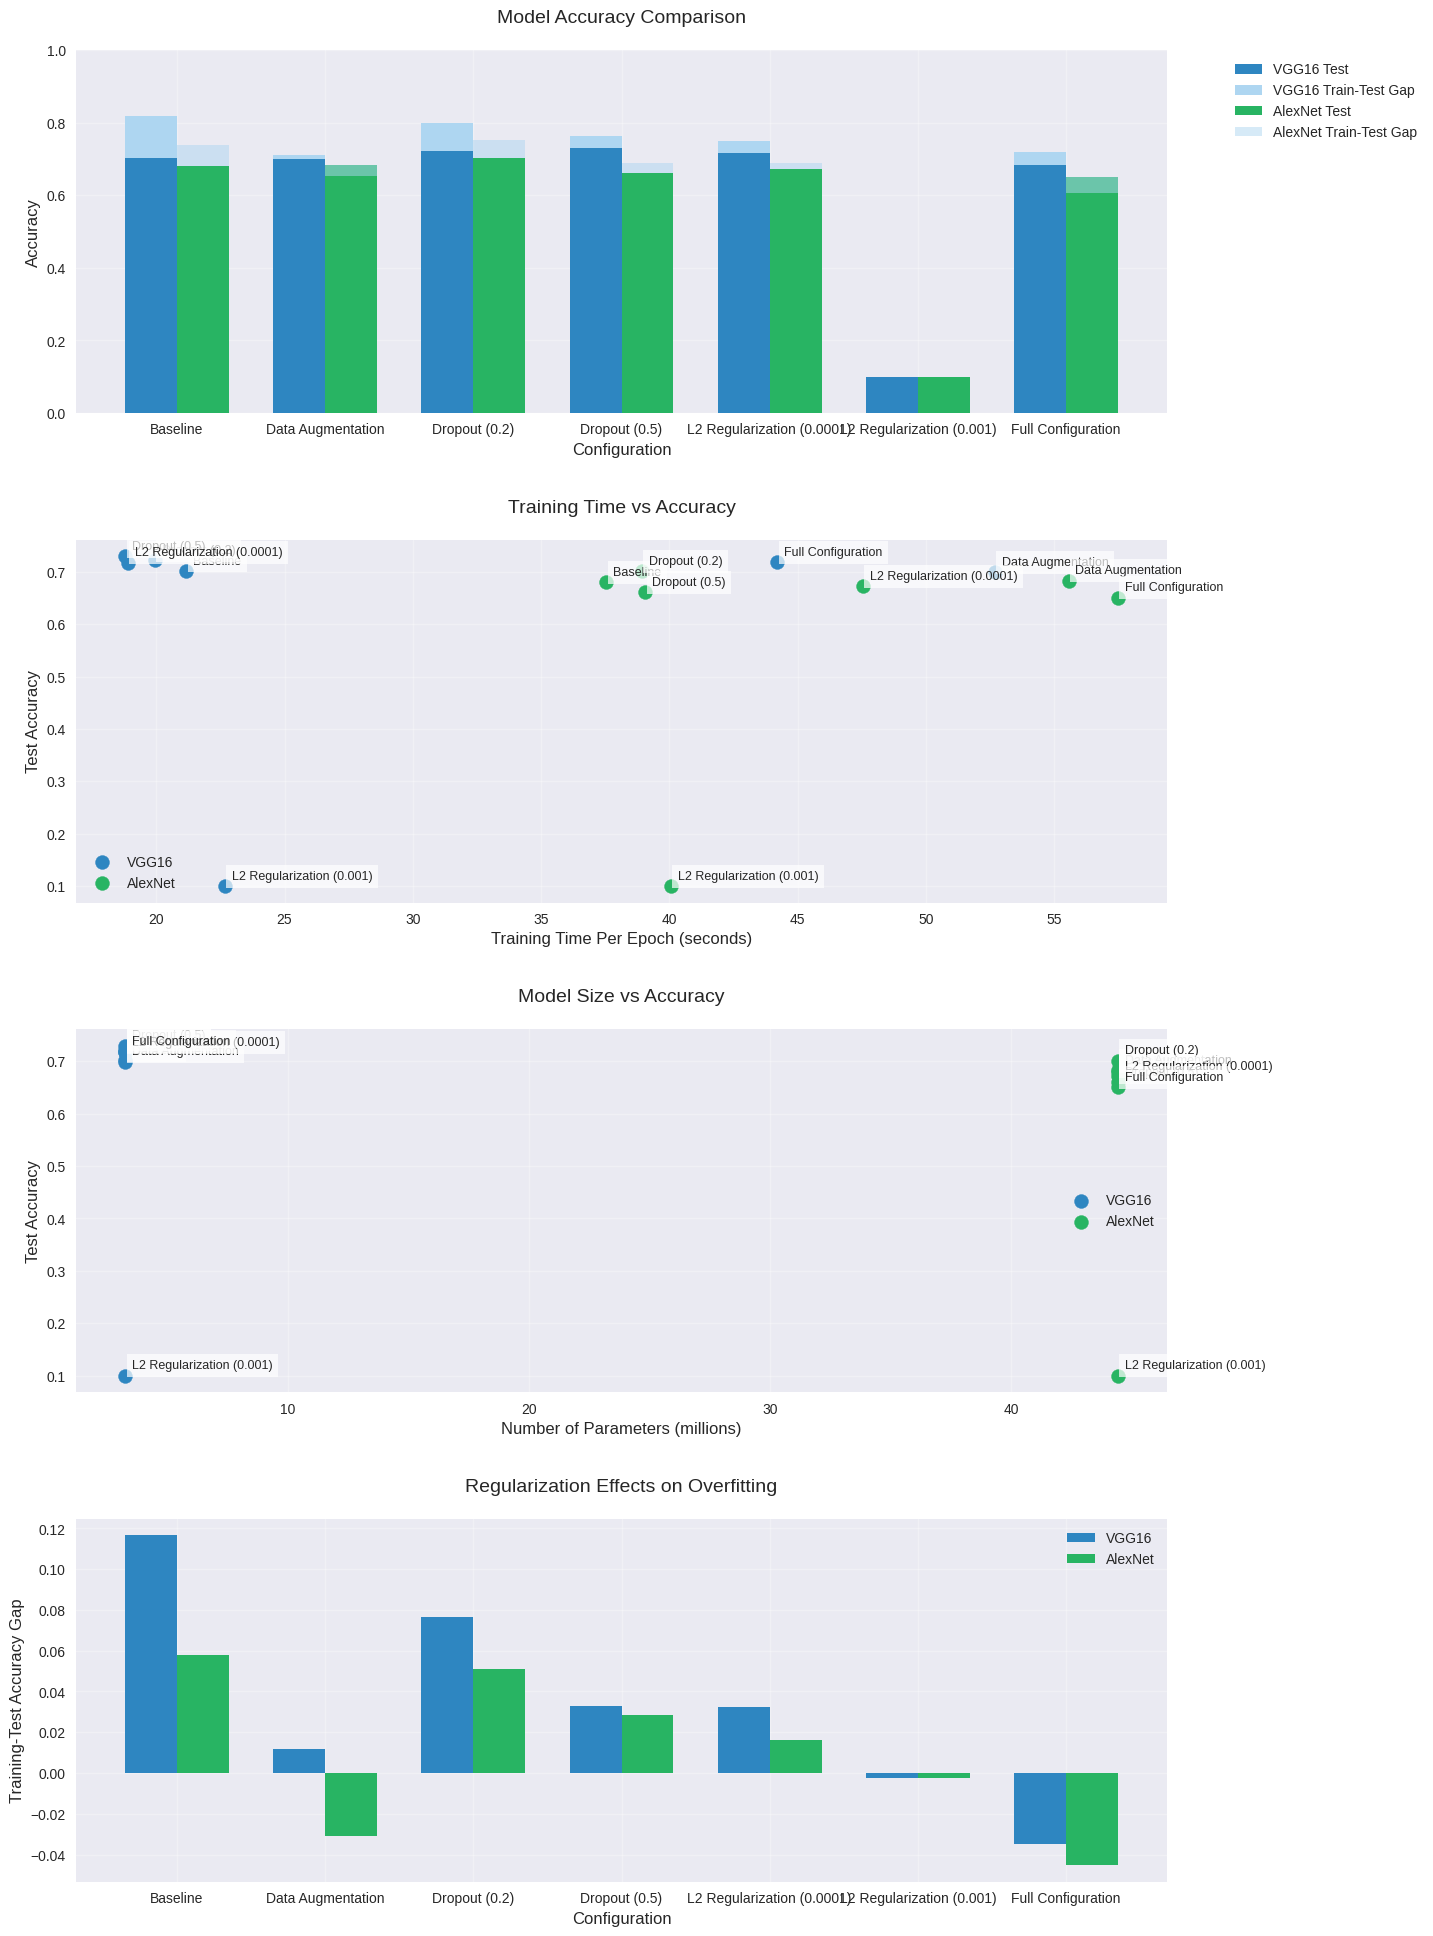

In [ ]:
visualizations(results_df)